In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import xarray as xr

import pop_tools

import util

USER = os.environ['USER']

In [3]:
diro = f'/glade/work/{USER}/onets-cases/data/forcing/fe-fert-forcing'
file_out = f'{diro}/fe-fert-text.nc'

In [4]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

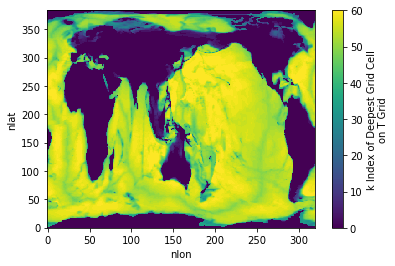

In [5]:
grid.KMT.plot()

In [6]:
time_bnds = xr.cftime_range('1999-01-01', '2020-01-01', freq='1D', calendar='noleap')
time_bnds = xr.DataArray(np.vstack((time_bnds[:-1], time_bnds[1:])).T, dims=('time', 'd2'))
time = time_bnds.mean('d2')
time_bnds

<xarray.DataArray (time: 7665, d2: 2)>
array([[cftime.DatetimeNoLeap(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1999, 1, 2, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1999, 1, 2, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1999, 1, 3, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1999, 1, 3, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1999, 1, 4, 0, 0, 0, 0, has_year_zero=True)],
       ...,
       [cftime.DatetimeNoLeap(2019, 12, 29, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2020, 1, 1, 0, 0, 0, 0, has_year_zero=True)]],
      dtype=object)
Dimensions without coordinates: time, d2

Simple approach to setting forcing magnitude:
- compute a mixed layer inventory
- set timescale for restoring that inventory
- compute flux as ratio of inventory to timescale

In [7]:
mld = 50.0 # m
fe_conc = 3.0 # nM
tau = 30 # days
fe_ml_inventory = fe_conc * mld * 1.0e3 * 1.0e-9 # mol/m^2
fe_fert_forcing_baseline = fe_ml_inventory / tau / 86400.0 # mol/m^2/s
fe_fert_forcing_baseline

5.7870370370370374e-11

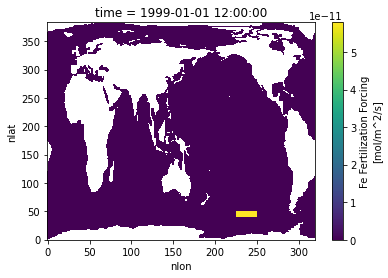

In [8]:
fe_fert_forcing = xr.full_like(grid.TLAT.expand_dims({'time': time}), fill_value=0.0)
fe_fert_forcing.name = 'fe_fert_forcing'
fe_fert_forcing.attrs['long_name'] = 'Fe Fertilization Forcing'
fe_fert_forcing.attrs['units'] = 'mol/m^2/s'

I_range = np.arange(225, 250, 1)
J_range = np.arange(40, 50, 1)

fe_fert_forcing[:31, J_range, I_range] = fe_fert_forcing_baseline
fe_fert_forcing.isel(time=0).where(grid.KMT > 0).plot()

In [9]:
dso = xr.Dataset(dict(
    time=time,
    time_bnds=time_bnds,
    fe_fert_forcing=fe_fert_forcing,
    TLAT=grid.TLAT,
    TLONG=grid.TLONG,
    KMT=grid.KMT,
    TAREA=grid.TAREA,
)).set_coords(['time', 'TLAT', 'TLONG']).rename({'nlat': 'Y', 'nlon': 'X'})
dso['Y'] = xr.DataArray(np.arange(1, grid.sizes['nlat']+1), dims=('Y'))
dso['X'] = xr.DataArray(np.arange(1, grid.sizes['nlon']+1), dims=('X'))
dso.time.encoding['dtype'] = np.float64
dso.time.encoding['_FillValue'] = None
dso.time.encoding['units'] = 'days since 1999-01-01 00:00:00'
dso.time_bnds.encoding['dtype'] = np.float64
dso.time_bnds.encoding['_FillValue'] = None
dso.time.attrs['bounds'] = 'time_bnds'
dso

<xarray.Dataset>
Dimensions:          (time: 7665, d2: 2, Y: 384, X: 320)
Coordinates:
  * time             (time) object 1999-01-01 12:00:00 ... 2019-12-31 12:00:00
    TLAT             (Y, X) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG            (Y, X) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
  * Y                (Y) int64 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * X                (X) int64 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
Dimensions without coordinates: d2
Data variables:
    time_bnds        (time, d2) object 1999-01-01 00:00:00 ... 2020-01-01 00:...
    fe_fert_forcing  (time, Y, X) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KMT              (Y, X) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TAREA            (Y, X) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12

In [10]:
dirname = os.path.dirname(file_out)
os.makedirs(dirname, exist_ok=True)

util.to_netcdf_clean(dso, file_out)

------------------------------
Writing /glade/work/mclong/onets-cases/data/forcing/fe-fert-forcing/fe-fert-text.nc

netcdf fe-fert-text {
dimensions:
	Y = 384 ;
	X = 320 ;
	time = 7665 ;
	d2 = 2 ;
variables:
	int KMT(Y, X) ;
		KMT:long_name = "k Index of Deepest Grid Cell on T Grid" ;
		KMT:coordinates = "TLAT TLONG" ;
	float TAREA(Y, X) ;
		TAREA:units = "cm^2" ;
		TAREA:long_name = "area of T cells" ;
		TAREA:coordinates = "TLAT TLONG" ;
	double TLAT(Y, X) ;
		TLAT:units = "degrees_north" ;
		TLAT:long_name = "T-grid latitude" ;
	double TLONG(Y, X) ;
		TLONG:units = "degrees_east" ;
		TLONG:long_name = "T-grid longitude" ;
	int X(X) ;
	int Y(Y) ;
	float fe_fert_forcing(time, Y, X) ;
		fe_fert_forcing:units = "mol/m^2/s" ;
		fe_fert_forcing:long_name = "Fe Fertilization Forcing" ;
		fe_fert_forcing:coordinates = "TLAT TLONG" ;
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1999-01-01" ;
		time:calendar = "noleap" ;
	double time_bnds(time, d2) ;

// globa